# Girl with a Perl Earring

Data explorationa and model prototype for the midterm project.

![](images/pearl_earring_small.jpg)
[Girl with Pearl Earring by Jan Vermeer](https://commons.wikimedia.org/wiki/File:Girl_with_a_Pearl_Earring.jpg?uselang=de)

In [7]:
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, PolynomialFeatures

In [8]:
im = Image.open('images/pearl_earring.jpg')
im.size

(649, 767)

In [9]:
a = np.array(im)
a.shape

(767, 649, 3)

In [10]:
cols, rows = im.size
rows, cols

(767, 649)

## 1. Exploratory Analysis

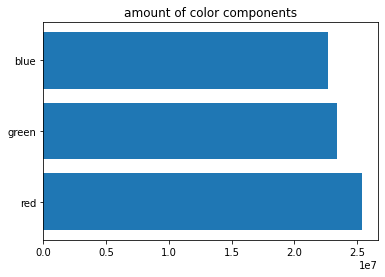

In [11]:
colorsums = a.sum(axis=(0,1))
plt.barh(['red', 'green', 'blue'], colorsums)
plt.title('amount of color components')
None

In [12]:
red = a[:,:,0]
green = a[:,:,1]
blue = a[:,:,2]

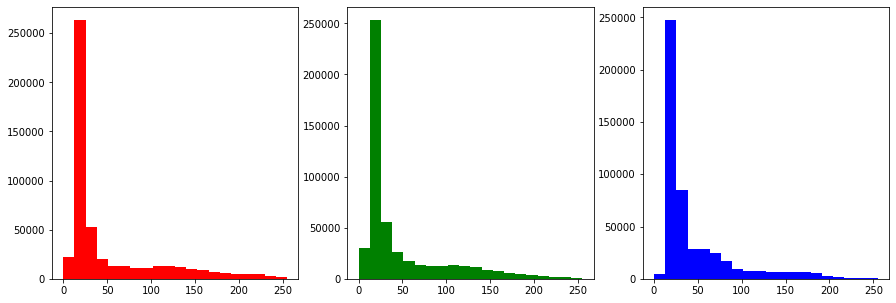

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(red.flatten(), bins=20, color='red')
plt.subplot(1,3,2)
plt.hist(green.flatten(), bins=20, color='green')
plt.subplot(1,3,3)
plt.hist(blue.flatten(), bins=20, color='blue')
None

apparently, there is lots of dark in the picture ;-). The model will have to deal with that imbalance in the target variable!

### 2. Data Wrangling

In [14]:
x, y = np.meshgrid(range(cols), range(rows))
coords = list(zip(y.flatten(), x.flatten()))

In [15]:
data = [(yy, xx, red[yy, xx], green[yy, xx], blue[yy, xx]) for yy, xx in coords]
df = pd.DataFrame(data, columns=('y', 'x', 'red', 'green', 'blue'))
df.head()

,y,x,red,green,blue
0,0,0,21,22,24
1,0,1,21,22,24
2,0,2,21,22,24
3,0,3,22,23,25
4,0,4,23,24,26


In [16]:
df.describe()

,y,x,red,green,blue
count,497783.000000,497783.000000,497783.000000,497783.000000,497783.00000
mean,383.000000,324.000000,50.967954,46.962417,45.47688
std,221.413862,187.350128,55.470951,49.652837,42.50617
min,0.000000,0.000000,0.000000,0.000000,0.00000
25%,191.000000,162.000000,17.000000,17.000000,21.00000
50%,383.000000,324.000000,22.000000,22.000000,25.00000
75%,575.000000,486.000000,64.000000,55.000000,54.00000
max,766.000000,648.000000,255.000000,255.000000,255.00000


#### Remove dark pixels to see the rest of the histogram

In [17]:
coldf = df[(df['red']>50)|(df['green']>50)|(df['blue']>50)]

In [18]:
coldf.describe()

,y,x,red,green,blue
count,152495.000000,152495.000000,152495.000000,152495.000000,152495.000000
mean,425.926876,374.752156,119.635614,107.673773,94.888468
std,187.059126,98.351920,55.803627,51.067196,47.865870
min,0.000000,0.000000,0.000000,12.000000,0.000000
25%,264.000000,300.000000,74.000000,64.000000,58.000000
50%,415.000000,361.000000,115.000000,102.000000,78.000000
75%,584.000000,438.000000,157.000000,142.000000,126.000000
max,766.000000,648.000000,255.000000,255.000000,255.000000


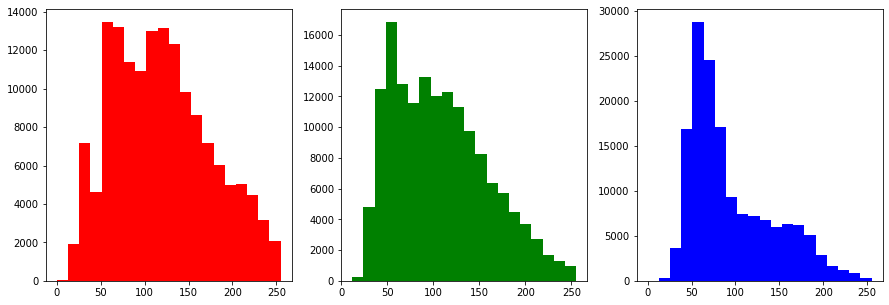

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(coldf['red'], bins=20, color='red')
plt.subplot(1,3,2)
plt.hist(coldf['green'], bins=20, color='green')
plt.subplot(1,3,3)
plt.hist(coldf['blue'], bins=20, color='blue')
None

### 3. Train-Test-Split

train 60% , val 20%, test 20%

In [20]:
tval, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(df, test_size=0.25, random_state=42)

### 4. Predict Red / Green / Blue from coordinates

In [21]:
def rgb_model(m, train, val):
    """
    Trains a model separately for 3 color channels.
    Then predicts the color for each color channel 
    separately and returns the resulting image
    """
    Xtrain = train[['x', 'y']]
    Xval = val[['x', 'y']]
    result = np.zeros((rows, cols, 3), dtype=np.uint8)
    
    for i, col in enumerate(['red', 'green', 'blue']):
        col_train = train[col]
        col_val = val[col]
    
        m.fit(Xtrain, col_train)
        trainscore = m.score(Xtrain, col_train)
        valscore = m.score(Xval, col_val)
        print(f'{col}\t'
              f'training R²   : {trainscore:6.3f}\t'
              f'validation R² : {valscore:6.3f}') 

        pred = m.predict(df[['x', 'y']])
        pred = pred.reshape((rows, cols)).astype(np.uint8)
        result[:,:,i] = pred
        
    return Image.fromarray(result)

In [22]:
def halfsize(im):
    return im.resize((im.size[0]//2, im.size[1]//2))

#### 4.1 Vanilla LinReg

red	training R²   :  0.032	validation R² :  0.032
green	training R²   :  0.029	validation R² :  0.030
blue	training R²   :  0.017	validation R² :  0.017


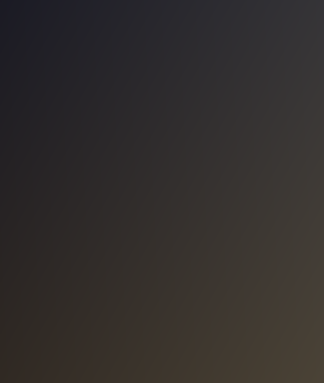

In [23]:
m = LinearRegression()
halfsize(rgb_model(m, train, val))

we see pretty much nothing. Apparently, 9 model parameters are not enough to fit a Vermeer. It might be sufficient to fit an elephant though.

#### 4.2 Bins with interaction terms

Here we apply two feature engineering tricks: cutting each feature into slices and then multiplying the x and y slices.
Effectively, this divides the data into little rectangles that the model can recognize individually.

red	training R²   :  0.704	validation R² :  0.703
green	training R²   :  0.683	validation R² :  0.682
blue	training R²   :  0.679	validation R² :  0.677


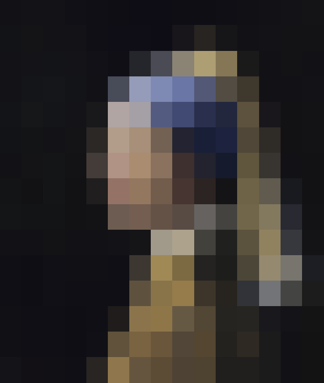

In [24]:
m = make_pipeline(
    KBinsDiscretizer(n_bins=15, encode='onehot'),
    PolynomialFeatures(interaction_only=True),
    LinearRegression()
)
halfsize(rgb_model(m, train, val))

#### 4.3 Decision Tree

With a decision tree regressor, we let the model find out the bin boundaries itself.
This gives a nice effect because the boundaries are different for each color channel.

red	training R²   :  0.826	validation R² :  0.823
green	training R²   :  0.802	validation R² :  0.798
blue	training R²   :  0.821	validation R² :  0.814


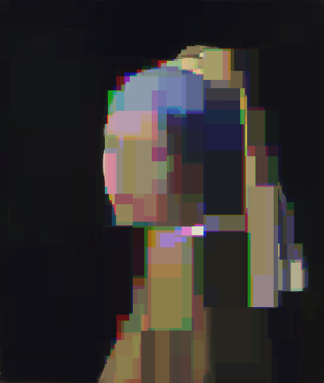

In [25]:
m = DecisionTreeRegressor(max_depth=10)
halfsize(rgb_model(m, train, val))

#### 4.4 RandomForest
The outcome of a Random Forest is not that much different. The RF works best when it has many features to (randomly) choose from. I tried to let the RF work on binned data but it only made the calculation last longer.

red	training R²   :  0.796	validation R² :  0.768
green	training R²   :  0.764	validation R² :  0.746
blue	training R²   :  0.788	validation R² :  0.758


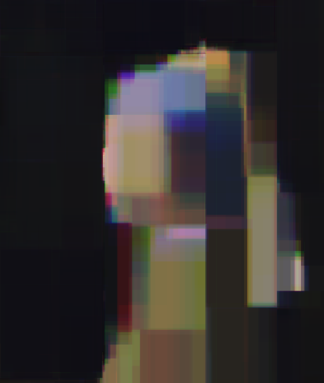

In [26]:
m = RandomForestRegressor(n_estimators=10, max_depth=8)
halfsize(rgb_model(m, train[:10000], val[:10000]))

#### 4.5 Support Vector Machine

The SVM applies some weird math that is potentially beautiful. I train it on 1000 pixels only because the SVM scales badly for big datasets. It doesn't work too well, as the SVM is also strongest with lots of features.

red	training R²   :  0.708	validation R² :  0.588
green	training R²   :  0.692	validation R² :  0.567
blue	training R²   :  0.694	validation R² :  0.564


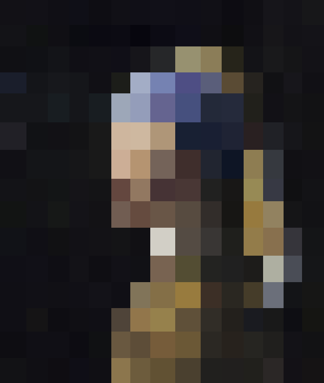

In [27]:
m = make_pipeline(
    KBinsDiscretizer(n_bins=15, encode='onehot-dense'),
    MinMaxScaler(),
    SVR(C=1000.0, kernel='rbf')
)
halfsize(rgb_model(m, train[:1000], val[:1000]))

The result is kind of the same as the LinReg, so I'll prefer the simpler (and much faster) one.


## Conclusion

I'd like to use the binned LinReg and the DecisionTree to let users upload their own data.